In [1]:
import sys

sys.path.insert(0, "/home/tsurendr/OAI_Skeletal_Radiology_Code_Working")
sys.path
%pip install -U pandas==1.5.3


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import lifelines
import math
import sys
from statistics import stdev
from lifelines.statistics import logrank_test, multivariate_logrank_test,pairwise_logrank_test

# Set the path of SBL and merge1 files and read the files
loc_data = "/data_1/OAI_SBL_Analysis_Data/"
loc_module = "/home/tsurendr/OAI_Github_scripts"
loc_data_SBL = loc_data + "SBL_0904.csv"
loc_merge1 = loc_data + "merge1_KL.csv"
raw_data_SBL = pd.read_csv(loc_data_SBL)
merge1 = pd.read_csv(loc_merge1)
# load custom module 
sys.path.append(loc_module)

In [3]:
sbl_col_names = ["F" + str(i) for i in range(200)] + [
    "T" + str(i) for i in range(200)
]  # femur: F0~ F199 , tibia: T0 ~ T199
sbl_col_names_femur = ["F" + str(i) for i in range(200)]
sbl_col_names_tibia = ["T" + str(i) for i in range(200)]

In [4]:
# ##################################
# # In this model we are using RAW SBL VALUES#
# ##################################
# raw_sbl_values = raw_data_SBL.loc[:, sbl_col_names].values
# # print(raw_data_SBL)
# sbl_values = np.empty_like(raw_sbl_values)  # for saving normalized SBL
# for row in range(raw_sbl_values.shape[0]):
#     sbl_values[row, :] = (
#         raw_sbl_values[row, :] / raw_sbl_values[row, :].mean()
#     )  # normalize by the averaged val. of SBL
# df_normalized_SBL = pd.DataFrame(sbl_values, columns=sbl_col_names)
# # get mean of Kellgren Lawrence (KL) grade 0
# sbl_KL_0_mean = df_normalized_SBL.loc[
#     (merge1["KL_Grade"] == 0) , sbl_col_names
# ].values.mean(0)

# print(f"shape of sbl_KL_0_mean: {sbl_KL_0_mean.shape}")
# baseline = sbl_KL_0_mean
# sbl_difference = df_normalized_SBL.loc[:, sbl_col_names].sub(baseline, axis=1)
# # absolute value of sbl difference.
# sbl_difference_absolute = sbl_difference.abs()
# sbl_difference_absolute.name = "normalized_sbl"
df_normalized_SBL_both = pd.DataFrame(raw_data_SBL)
df_normalized_SBL_both = df_normalized_SBL_both.add_suffix('_merged')
# df_normalized_SBL_both['SBL_difference_merged'] = df_normalized_SBL_both.sum(axis=1)

df_normalized_SBL_both.drop(columns=df_normalized_SBL_both.columns[0], axis=1,  inplace=True)
df_normalized_SBL_both.drop(columns=df_normalized_SBL_both.columns[-1], axis=1,  inplace=True)
df_normalized_SBL_both.drop(columns=df_normalized_SBL_both.columns[-1], axis=1,  inplace=True)
print(df_normalized_SBL_both)

      F0_merged  F1_merged  F2_merged  F3_merged  F4_merged  F5_merged  \
0           4.0   3.532079   2.297244   0.093239   0.000000   0.000000   
1           3.0   0.180653   3.549661  31.076046  46.106151  55.543236   
2           3.0   5.358804   5.951435   3.999878   3.000000   3.000000   
3           0.0   0.000000   1.037586   8.400008  37.597578  60.490127   
4           0.0   0.000000   0.000000   0.000000   0.395532   3.030169   
...         ...        ...        ...        ...        ...        ...   
9429        4.0   0.312965   0.808443   7.923382  19.633445  36.613096   
9430        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
9431        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
9432        0.0   0.000000   0.000000   0.000000   0.049816   5.269794   
9433        6.0   1.408218   0.000000   0.000000   0.000000   0.000000   

      F6_merged  F7_merged  F8_merged  F9_merged  ...  T190_merged  \
0      0.000000   0.000000   0.000000   0

In [5]:
# Combining 3 Variables: df_normalized_SBL_both, df_normalized_SBL_femur, df_normalized_SBL_tibia
data_SBL = pd.merge(
    raw_data_SBL, df_normalized_SBL_both, right_index=True, left_index=True
)  # merge df_normalized_SBL_both


In [6]:
# Splitting data by knee side(right/left) and formatting columns appropriately 
print("total number of baseline knees", len(data_SBL))
data_SBL["id"] = data_SBL["id"].astype(str)
data_BioMarkers = pd.read_csv(loc_data + "Biomarker_data.csv")
data_SBL = data_SBL.drop(["Unnamed: 0"], axis=1)
data_BioMarkers = data_BioMarkers.drop(["Unnamed: 0"], axis=1)
side_SBL_temp = data_SBL.groupby("SIDE")
side_1_SBL_Right = side_SBL_temp.get_group(1)
side_2_SBL_Left = side_SBL_temp.get_group(2)

total number of baseline knees 9434


In [7]:
print("total number of right knees", len(side_1_SBL_Right))
print("total number of left knees", len(side_2_SBL_Left))

total number of right knees 4727
total number of left knees 4707


In [8]:
# settings
NUM_YEARS = 11.0 
encoding = "utf-8"
# read and preprocessing
raw_df = pd.read_sas(loc_data + "outcomes99.sas7bdat")
# must censor data per knee
print("Before data drop mri data", len(raw_df))
df = raw_df.dropna(axis=0, subset=["V99RNTCNT"])
print("complete mri data", len(df))
print(f"number of drop: {len(raw_df)-len(df)}")
df = df.copy()
df.loc[:, "id"] = df["id"].apply(lambda x: str(x, encoding))
merge1 = merge1.dropna(axis=0, subset=["P02SEX"])
merge1 = merge1.dropna(axis=0, subset=["V00AGE"])
merge1 = merge1.dropna(axis=0, subset=["V00XRJSM"])
merge1 = merge1.dropna(axis=0, subset=["V00XRJSL"])
merge1["id"] = merge1["id"].astype(str)
merge1_temp = merge1.groupby("SIDE")
merge1_right = merge1_temp.get_group(1)
merge1_left = merge1_temp.get_group(2)
df_8_years = df[df["V99RNTCNT"] <= NUM_YEARS].copy()
print("oai Data: ", len(df_8_years))

Before data drop mri data 4796
complete mri data 4650
number of drop: 146
oai Data:  4650


In [9]:
# KL Grade information preprocessing for right knees
data_KL_grade_right = pd.read_csv(loc_data + "rightFilteredklMEAS.csv")
data_KL_grade_right = data_KL_grade_right.drop(["Unnamed: 0"], axis=1)
data_KL_grade_right = data_KL_grade_right.dropna(axis=0, subset=["V00XRKLR"])
data_KL_grade_right["id"] = data_KL_grade_right["id"].astype(str)

In [10]:
# KL Grade information preprocessing for left knees
data_KL_grade_left = pd.read_csv(loc_data + "leftFilteredklMEAS.csv")
data_KL_grade_left = data_KL_grade_left.drop(["Unnamed: 0"], axis=1)
data_KL_grade_left = data_KL_grade_left.dropna(axis=0, subset=["V00XRKLL"])
data_KL_grade_left["id"] = data_KL_grade_left["id"].astype(str)

In [11]:
# BML information preprocessing for right knees. 
# right side
data_BML_right = pd.read_csv(loc_data + "rightFilteredbmlMoaks.csv")
data_BML_right["id"] = data_BML_right["id"].astype(str)

data_BML_right = data_BML_right.drop(["Unnamed: 0"], axis=1)
data_BML_right = data_BML_right.dropna(axis=0, subset=['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP',
'V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP'])

# For verification after data processing
print("bml right Data: ", len(data_BML_right))


bml right Data:  1587


In [12]:
# Race Data, dropping patients with missing data
race_data = pd.read_csv('/data_1/OAI_Backup/MeasInventory.csv')
race_data = race_data.dropna(axis=0, subset=['P02RACE'])
race_data = race_data.drop(columns=['V00AGE'])
race_data = race_data.drop(columns=['P02SEX'])
race_data = race_data.drop(columns=['V00XRKLR'])
race_data = race_data.drop(columns=['V00XRKLL'])
race_data['id'] = race_data['id'].astype(str)


In [13]:
# Merging all right knee info, including demographics, TKR, KL Grade, BML, etc...
oai_bml_merge_right = pd.merge(df_8_years, data_BML_right, how="inner", on=["id"])
oai_bml_SBL_KL_merge_right_pre = pd.merge(
    oai_bml_merge_right, side_1_SBL_Right, how="inner", on=["id"]
)
print(len(oai_bml_SBL_KL_merge_right_pre))

oai_bml_SBL_KL_merge_right_age_pre_1 = pd.merge(
    oai_bml_SBL_KL_merge_right_pre, data_KL_grade_right, how="inner", on=["id"]
)
oai_bml_SBL_KL_merge_right_pre = pd.merge(
    oai_bml_SBL_KL_merge_right_age_pre_1, merge1_right, how="inner", on=["id"]
)


oai_bml_SBL_KL_merge_right = pd.merge(
    oai_bml_SBL_KL_merge_right_pre, race_data, how="inner", on=["id"]
)
print(len(oai_bml_SBL_KL_merge_right))

oai_bml_SBL_KL_merge_right.drop_duplicates(subset=["id"], inplace=True, keep="last")
oai_bml_SBL_KL_merge_right.reset_index(drop=True, inplace=True)
print(len(oai_bml_SBL_KL_merge_right))


1587
1584
1257


In [14]:
if 'V00XRJSM' in oai_bml_SBL_KL_merge_right:
    print(True)
else:
    print(False)

True


In [15]:
if 'V00XRJSL' in oai_bml_SBL_KL_merge_right:
    print(True)
else:
    print(False)

True


In [16]:
# BML information preprocessing for left knees. 
# left side
data_BML_left = pd.read_csv(loc_data + "leftFilteredbmlMoaks.csv")
data_BML_left["id"] = data_BML_left["id"].astype(str)

data_BML_left = data_BML_left.drop(["Unnamed: 0"], axis=1)
data_BML_left = data_BML_left.dropna(axis=0, subset=['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP',
'V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP'])

# For verification after data processing
print("bml left Data: ", len(data_BML_left))

bml left Data:  1366


In [17]:
# Merging all left knee info, including demographics, TKR, KL Grade, BML, etc...
oai_bml_merge_left = pd.merge(df_8_years, data_BML_left, how="inner", on=["id"])
oai_bml_SBL_KL_merge_left_pre = pd.merge(
    oai_bml_merge_left, side_2_SBL_Left, how="inner", on=["id"]
)
oai_bml_SBL_KL_merge_left_age_pre_1 = pd.merge(
    oai_bml_SBL_KL_merge_left_pre, data_KL_grade_left, how="inner", on=["id"]
) 

oai_bml_SBL_KL_merge_left_pre = pd.merge(
    oai_bml_SBL_KL_merge_left_age_pre_1, merge1_left, how="inner", on=["id"]
)

oai_bml_SBL_KL_merge_left = pd.merge(
    oai_bml_SBL_KL_merge_left_pre, race_data, how="inner", on=["id"]
)
oai_bml_SBL_KL_merge_left.drop_duplicates(subset=["id"], inplace=True, keep="last")
oai_bml_SBL_KL_merge_left.reset_index(drop=True, inplace=True)
print(len(oai_bml_SBL_KL_merge_left))


1083


In [18]:
if 'V00XRJSM' in oai_bml_SBL_KL_merge_left:
    print(True)
else:
    print(False)

True


In [19]:
if 'V00XRJSL' in oai_bml_SBL_KL_merge_left:
    print(True)
else:
    print(False)

True


In [20]:
print(oai_bml_SBL_KL_merge_right['V00XRJSM'].isnull().sum())
print(oai_bml_SBL_KL_merge_right['V00XRJSL'].isnull().sum())

0
0


In [21]:
print(oai_bml_SBL_KL_merge_left['V00XRJSM'].isnull().sum())
print(oai_bml_SBL_KL_merge_left['V00XRJSL'].isnull().sum())

0
0


In [22]:
# need 3 groups representing merged femur and tibia. 

femur_column_list = ['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP']

tibia_column_list = ['V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP']

merged_column_list = ['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP',
'V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP']


In [23]:
# Determining the largest BML in each knee based on if it is a Merged, Femur, or Tibia model
# For both left and right knees

# right side
right_knee_tkr = oai_bml_SBL_KL_merge_right[
    (oai_bml_SBL_KL_merge_right["V99RNTCNT"] <= NUM_YEARS)
    & (oai_bml_SBL_KL_merge_right["V99ERKDAYS"].isnull() == False)
]
print("total knees on right side: ", len(oai_bml_SBL_KL_merge_right))
print("censored right knees: ", len(oai_bml_SBL_KL_merge_right) - len(right_knee_tkr))
print("proper right knee tkr: ", len(right_knee_tkr))

oai_bml_SBL_KL_merge_right["right_tkr"] = np.where(
    oai_bml_SBL_KL_merge_right["id"].isin(right_knee_tkr["id"]) == True, 1, 0
)
oai_bml_SBL_KL_merge_right["bml_total_merged"] = oai_bml_SBL_KL_merge_right[merged_column_list].max(axis=1)
oai_bml_SBL_KL_merge_right["bml_total_femur"] = oai_bml_SBL_KL_merge_right[femur_column_list].max(axis=1)
oai_bml_SBL_KL_merge_right["bml_total_tibia"] = oai_bml_SBL_KL_merge_right[tibia_column_list].max(axis=1)
print(oai_bml_SBL_KL_merge_right["bml_total_merged"].unique())

# left side
left_knee_tkr = oai_bml_SBL_KL_merge_left[
    (oai_bml_SBL_KL_merge_left["V99RNTCNT"] <= NUM_YEARS)
    & (oai_bml_SBL_KL_merge_left["V99ELKDAYS"].isnull() == False)
]

print("total knees on left side: ", len(oai_bml_SBL_KL_merge_left))
print("censored left knees: ", len(oai_bml_SBL_KL_merge_left) - len(left_knee_tkr))
print("proper left knee tkr: ", len(left_knee_tkr))


oai_bml_SBL_KL_merge_left["right_tkr"] = np.where(
    oai_bml_SBL_KL_merge_left["id"].isin(left_knee_tkr["id"]) == True, 1, 0
)

oai_bml_SBL_KL_merge_left["bml_total_merged"] = oai_bml_SBL_KL_merge_left[merged_column_list].max(axis = 1)
oai_bml_SBL_KL_merge_left["bml_total_femur"] = oai_bml_SBL_KL_merge_left[femur_column_list].max(axis = 1)
oai_bml_SBL_KL_merge_left["bml_total_tibia"] = oai_bml_SBL_KL_merge_left[tibia_column_list].max(axis = 1)
print(oai_bml_SBL_KL_merge_left["bml_total_merged"].unique())

print(oai_bml_SBL_KL_merge_right)

total knees on right side:  1257
censored right knees:  1084
proper right knee tkr:  173
[1. 2. 3. 0.]
total knees on left side:  1083
censored left knees:  923
proper left knee tkr:  160
[3. 2. 1. 0.]
           id version  V99RNTCNT V99ERKDATE  V99ERKFLDT  V99ERKRPCF_x  \
0     9001400   b'10'       11.0        NaT         NaN           NaN   
1     9001695   b'10'        9.0        NaT         NaN           NaN   
2     9001897   b'10'       11.0        NaT         NaN           NaN   
3     9002430   b'10'       11.0 2010-02-15         1.0           3.0   
4     9002817   b'10'       11.0        NaT         NaN           NaN   
...       ...     ...        ...        ...         ...           ...   
1252  9996098   b'10'       11.0        NaT         NaN           NaN   
1253  9996865   b'10'       11.0        NaT         NaN           NaN   
1254  9997381   b'10'       11.0        NaT         NaN           NaN   
1255  9999510   b'10'       11.0        NaT         NaN           Na

In [24]:
# Renaming right knee columns for ease of use

oai_bml_SBL_KL_merge_right = oai_bml_SBL_KL_merge_right.rename(columns = {"V00AGE":'AGE', "V00XRKLR":'KL_grade',"P01BMI":'BMI',"P02RACE":'RACE'})
print('RACE' in oai_bml_SBL_KL_merge_right)
print("KL_grade" in oai_bml_SBL_KL_merge_right.columns.tolist() )

True
True


In [25]:
# Renaming left knee columns for ease of use

oai_bml_SBL_KL_merge_left = oai_bml_SBL_KL_merge_left.rename(columns = {"V00AGE":'AGE',"V00XRKLL":'KL_grade',"P01BMI":'BMI',"P02RACE":'RACE'})
print("RACE" in oai_bml_SBL_KL_merge_left.columns.tolist() )

True


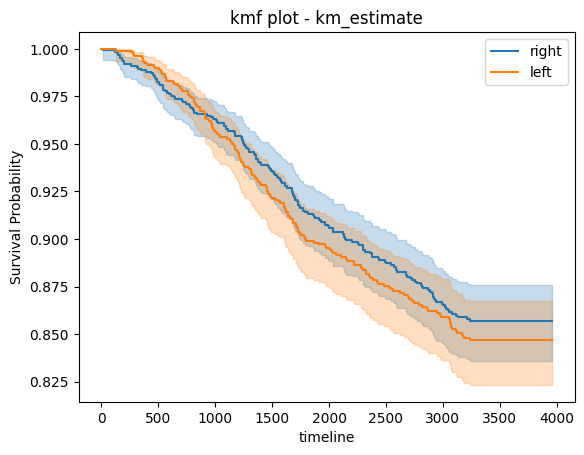

In [26]:
# Determining which patiets had a TKR and if not, what their most recent time of follow-up was.
from time_adder import add_time

oai_SBL_KL_BML_right = add_time(oai_bml_SBL_KL_merge_right, "right")
oai_SBL_KL_BML_left = add_time(oai_bml_SBL_KL_merge_left, "left")

In [27]:
# Selecting columns from left and right knee info, to merge into 1 table for each SBL and BML model
# right side
oai_right_temp_SBL_Merged_right = pd.concat( [oai_SBL_KL_BML_right.loc[:, 'F0_merged':'T199_merged'], oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX",'KL_grade', 'RACE','bml_total_merged','bml_total_femur','bml_total_tibia','AGE','BMI']]], axis = 1)

oai_right_temp_SBL_Femur_right = pd.concat( [oai_SBL_KL_BML_right.loc[:, 'F0_merged':'F199_merged'], oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX",'bml_total_femur','RACE','AGE','BMI','KL_grade']]], axis = 1)

oai_right_temp_SBL_Tibia_right = pd.concat( [oai_SBL_KL_BML_right.loc[:, 'T0_merged':'T199_merged'], oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX",'bml_total_tibia','RACE','AGE','BMI','KL_grade']]], axis = 1)


oai_right_temp_BML_Merged_right = oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX", "bml_total_merged",'RACE','AGE','BMI','KL_grade']
]
oai_right_temp_BML_Femur_right = oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX", "bml_total_femur",'RACE','AGE','BMI','KL_grade']
]
oai_right_temp_BML_Tibia_right = oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX", "bml_total_tibia",'RACE','AGE','BMI','KL_grade']
]

oai_right_temp_JSN_Merged_right = oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX", "V00XRJSM",'V00XRJSL','RACE','AGE','BMI','KL_grade']
]


# left side
oai_right_temp_SBL_Merged_left = pd.concat( [oai_SBL_KL_BML_left.loc[:, 'F0_merged':'T199_merged'], oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX",'KL_grade','RACE','bml_total_merged','bml_total_femur','bml_total_tibia','AGE','BMI']]], axis = 1)

oai_right_temp_SBL_Femur_left = pd.concat( [oai_SBL_KL_BML_left.loc[:, 'F0_merged':'F199_merged'], oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX",'bml_total_femur','RACE','AGE','BMI','KL_grade']]], axis = 1)

oai_right_temp_SBL_Tibia_left = pd.concat( [oai_SBL_KL_BML_left.loc[:, 'T0_merged':'T199_merged'], oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX",'bml_total_tibia','RACE','AGE','BMI','KL_grade']]], axis = 1)


oai_right_temp_BML_Merged_left = oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX", "bml_total_merged",'RACE','AGE','BMI','KL_grade']
]
oai_right_temp_BML_Femur_left = oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX", "bml_total_femur",'RACE','AGE','BMI','KL_grade']
]
oai_right_temp_BML_Tibia_left = oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX", "bml_total_tibia",'RACE','AGE','BMI','KL_grade']
]

oai_right_temp_JSN_Merged_left = oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX", "V00XRJSM",'V00XRJSL','RACE','AGE','BMI','KL_grade']
]





In [28]:
# merging information for various SBL and BML models based on left and right knee information that was selected previously

oai_right_temp_SBL_Merged_all = pd.concat(
    [oai_right_temp_SBL_Merged_right, oai_right_temp_SBL_Merged_left],
    ignore_index=True,
)
oai_right_temp_SBL_Femur_all = pd.concat(
    [oai_right_temp_SBL_Femur_right, oai_right_temp_SBL_Femur_left],
    ignore_index=True,
)
oai_right_temp_SBL_Tibia_all = pd.concat(
    [oai_right_temp_SBL_Tibia_right, oai_right_temp_SBL_Tibia_left],
    ignore_index=True,
)


oai_right_temp_BML_Merged_all = pd.concat(
    [oai_right_temp_BML_Merged_right, oai_right_temp_BML_Merged_left],
    ignore_index=True,
)
oai_right_temp_BML_Femur_all = pd.concat(
    [oai_right_temp_BML_Femur_right, oai_right_temp_BML_Femur_left],
    ignore_index=True,
)
oai_right_temp_BML_Tibia_all = pd.concat(
    [oai_right_temp_BML_Tibia_right, oai_right_temp_BML_Tibia_left],
    ignore_index=True,
)

oai_right_temp_JSN_Merged_all = pd.concat(
    [oai_right_temp_JSN_Merged_right, oai_right_temp_JSN_Merged_left],
    ignore_index=True,
)

oai_right_temp_SBL_Merged_all.drop(oai_right_temp_SBL_Merged_all[(oai_right_temp_SBL_Merged_all['RACE'] == '.D: Don t Know/Unknown/Uncertain') ].index, inplace=True)

In [29]:
# dropping the lowest BML size from patients who have 2 knees in the table in order to avoid confounding variables. 
oai_right_temp_SBL_Merged_all = oai_right_temp_SBL_Merged_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
oai_right_temp_SBL_Femur_all = oai_right_temp_SBL_Femur_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
oai_right_temp_SBL_Tibia_all = oai_right_temp_SBL_Tibia_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
oai_right_temp_BML_Merged_all = oai_right_temp_BML_Merged_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
oai_right_temp_BML_Femur_all = oai_right_temp_BML_Femur_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
oai_right_temp_BML_Tibia_all = oai_right_temp_BML_Tibia_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
oai_right_temp_JSN_Merged_all = oai_right_temp_JSN_Merged_all.sort_values('KL_grade').drop_duplicates('id', keep='last').sort_index()
#Checking to make sure each patient has no more than 1 knee in the table
print(len(list(set([x for i,x in enumerate(oai_right_temp_SBL_Merged_all['id'].tolist()) if oai_right_temp_SBL_Merged_all['id'].tolist().count(x) > 1]))))



0


In [30]:
groups_merged = oai_right_temp_SBL_Merged_all.groupby("P02SEX")
males_merged = groups_merged.get_group(1)
females_merged = groups_merged.get_group(2)
print("total males", len(males_merged))
# check the gender population; male:1, female:2
print('total females', len(females_merged))


total males 759
total females 1214


In [31]:

# grouping by sex
groups_merged = oai_right_temp_SBL_Merged_all.groupby("P02SEX")
males_merged = groups_merged.get_group(1)
females_merged = groups_merged.get_group(2)
males_merged = males_merged.drop(columns=["P02SEX"])
females_merged = females_merged.drop(columns=["P02SEX"])

groups_femur = oai_right_temp_SBL_Femur_all.groupby("P02SEX")
males_femur = groups_femur.get_group(1)
females_femur = groups_femur.get_group(2)
males_femur = males_femur.drop(columns=["P02SEX"])
females_femur = females_femur.drop(columns=["P02SEX"])

groups_tibia = oai_right_temp_SBL_Tibia_all.groupby("P02SEX")
males_tibia = groups_tibia.get_group(1)
females_tibia = groups_tibia.get_group(2)
males_tibia = males_tibia.drop(columns=["P02SEX"])
females_tibia = females_tibia.drop(columns=["P02SEX"])

groups_BML_merged = oai_right_temp_BML_Merged_all.groupby("P02SEX")
males_BML_merged = groups_BML_merged.get_group(1)
females_BML_merged = groups_BML_merged.get_group(2)


groups_BML_femur = oai_right_temp_BML_Femur_all.groupby("P02SEX")
males_BML_femur = groups_BML_femur.get_group(1)
females_BML_femur = groups_BML_femur.get_group(2)



groups_BML_tibia = oai_right_temp_BML_Tibia_all.groupby("P02SEX")
males_BML_tibia = groups_BML_tibia.get_group(1)
females_BML_tibia = groups_BML_tibia.get_group(2)


males_BML_merged = males_BML_merged.drop(columns=["P02SEX"])
females_BML_merged = females_BML_merged.drop(columns=["P02SEX"])

males_BML_femur = males_BML_femur.drop(columns=["P02SEX"])
females_BML_femur = females_BML_femur.drop(columns=["P02SEX"])

males_BML_tibia = males_BML_tibia.drop(columns=["P02SEX"])
females_BML_tibia = females_BML_tibia.drop(columns=["P02SEX"])


# Dropping irrelevent information from tables before input to Cox Models
oai_right_temp_SBL_Merged_all = oai_right_temp_SBL_Merged_all.drop(columns=["P02SEX",'id'])
oai_right_temp_SBL_Femur_all = oai_right_temp_SBL_Femur_all.drop(columns=["P02SEX",'id'])
oai_right_temp_SBL_Tibia_all = oai_right_temp_SBL_Tibia_all.drop(columns=["P02SEX",'id'])
oai_right_temp_BML_Merged_all = oai_right_temp_BML_Merged_all.drop(columns=["P02SEX",'id'])
oai_right_temp_BML_Femur_all = oai_right_temp_BML_Femur_all.drop(columns=["P02SEX",'id'])
oai_right_temp_BML_Tibia_all = oai_right_temp_BML_Tibia_all.drop(columns=["P02SEX",'id'])
oai_right_temp_JSN_Merged_all = oai_right_temp_JSN_Merged_all.drop(columns=["P02SEX",'id'])

In [32]:
# Creating a new column for Race data, converting it from a string to a int based group
oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['RACE'] == '3: Asian', 'Race_Group'] = 3

oai_right_temp_SBL_Femur_all.loc[oai_right_temp_SBL_Femur_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_SBL_Femur_all.loc[oai_right_temp_SBL_Femur_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_SBL_Femur_all.loc[oai_right_temp_SBL_Femur_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_SBL_Femur_all.loc[oai_right_temp_SBL_Femur_all['RACE'] == '3: Asian', 'Race_Group'] = 3

oai_right_temp_SBL_Tibia_all.loc[oai_right_temp_SBL_Tibia_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_SBL_Tibia_all.loc[oai_right_temp_SBL_Tibia_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_SBL_Tibia_all.loc[oai_right_temp_SBL_Tibia_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_SBL_Tibia_all.loc[oai_right_temp_SBL_Tibia_all['RACE'] == '3: Asian', 'Race_Group'] = 3

oai_right_temp_BML_Merged_all.loc[oai_right_temp_BML_Merged_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_BML_Merged_all.loc[oai_right_temp_BML_Merged_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_BML_Merged_all.loc[oai_right_temp_BML_Merged_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_BML_Merged_all.loc[oai_right_temp_BML_Merged_all['RACE'] == '3: Asian', 'Race_Group'] = 3

oai_right_temp_BML_Femur_all.loc[oai_right_temp_BML_Femur_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_BML_Femur_all.loc[oai_right_temp_BML_Femur_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_BML_Femur_all.loc[oai_right_temp_BML_Femur_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_BML_Femur_all.loc[oai_right_temp_BML_Femur_all['RACE'] == '3: Asian', 'Race_Group'] = 3

oai_right_temp_BML_Tibia_all.loc[oai_right_temp_BML_Tibia_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_BML_Tibia_all.loc[oai_right_temp_BML_Tibia_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_BML_Tibia_all.loc[oai_right_temp_BML_Tibia_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_BML_Tibia_all.loc[oai_right_temp_BML_Tibia_all['RACE'] == '3: Asian', 'Race_Group'] = 3


oai_right_temp_JSN_Merged_all.loc[oai_right_temp_JSN_Merged_all['RACE'] == '0: Other Non-white', 'Race_Group'] = 0
oai_right_temp_JSN_Merged_all.loc[oai_right_temp_JSN_Merged_all['RACE'] == '1: White or Caucasian', 'Race_Group'] = 1
oai_right_temp_JSN_Merged_all.loc[oai_right_temp_JSN_Merged_all['RACE'] == '2: Black or African American', 'Race_Group'] = 2
oai_right_temp_JSN_Merged_all.loc[oai_right_temp_JSN_Merged_all['RACE'] == '3: Asian', 'Race_Group'] = 3

In [33]:
# Dropping all nan's from datasets 
oai_right_temp_SBL_Merged_all=oai_right_temp_SBL_Merged_all.dropna(axis=0)
oai_right_temp_SBL_Femur_all=oai_right_temp_SBL_Femur_all.dropna(axis=0)
oai_right_temp_SBL_Tibia_all=oai_right_temp_SBL_Tibia_all.dropna(axis=0)
oai_right_temp_BML_Merged_all=oai_right_temp_BML_Merged_all.dropna(axis=0)
oai_right_temp_BML_Femur_all=oai_right_temp_BML_Femur_all.dropna(axis=0)
oai_right_temp_BML_Tibia_all=oai_right_temp_BML_Tibia_all.dropna(axis=0)
oai_right_temp_BML_Tibia_all=oai_right_temp_BML_Tibia_all.dropna(axis=0)
oai_right_temp_JSN_Merged_all=oai_right_temp_JSN_Merged_all.dropna(axis=0)
print(len(oai_right_temp_BML_Merged_all))

1970


In [34]:
# Selecting SBL, BML, AGE, BMI, Race, and KL Grade variables to create CPH models
oai_right_temp_SBL_Merged_all = pd.concat( [oai_right_temp_SBL_Merged_all.loc[:, 'F0_merged':'T199_merged'], oai_right_temp_SBL_Merged_all[
    ["time", "right_tkr", 'AGE','KL_grade','BMI', 'Race_Group']]], axis = 1)

oai_right_temp_SBL_Femur_all = pd.concat( [oai_right_temp_SBL_Femur_all.loc[:, 'F0_merged':'F199_merged'], oai_right_temp_SBL_Femur_all[
    ["time", "right_tkr", 'AGE','KL_grade','BMI', 'Race_Group']]], axis = 1)

oai_right_temp_SBL_Tibia_all = pd.concat( [oai_right_temp_SBL_Tibia_all.loc[:, 'T0_merged':'T199_merged'], oai_right_temp_BML_Tibia_all[
    ["time", "right_tkr", 'AGE','KL_grade','BMI', 'Race_Group']]], axis = 1)


oai_right_temp_BML_Merged_all = oai_right_temp_BML_Merged_all[
    ["time", "right_tkr",  "bml_total_merged",'AGE','KL_grade','BMI', 'Race_Group']
]
oai_right_temp_BML_Femur_all = oai_right_temp_BML_Femur_all[
    ["time", "right_tkr",  "bml_total_femur",'AGE','KL_grade','BMI', 'Race_Group']
]
oai_right_temp_BML_Tibia_all = oai_right_temp_BML_Tibia_all[
    ["time", "right_tkr",  "bml_total_tibia",'AGE','KL_grade','BMI', 'Race_Group']]

oai_right_temp_JSN_Merged_all = oai_right_temp_JSN_Merged_all[
    ["time", "right_tkr",  "V00XRJSM",'V00XRJSL','AGE','KL_grade','BMI', 'Race_Group']]

In [ ]:
from all_knee_sbl_bootstrap import cph_creator_SBL


In [35]:
# CPH Model for SBL Merged data for patients 
cindex_1, brier_1, auc_1  = cph_creator_SBL(oai_right_temp_SBL_Merged_all, True)

test1
old penalizer_val:  0.1
old dataframe length:  406
SBL_bool True
new dataframe length:  374
#################################### checkpoint 3
concordance index censored scikit:0.884
Brier Score 0.047


In [36]:
# CPH Model for SBL Femur data for patients 
cindex_2, brier_2, auc_2   = cph_creator_SBL(oai_right_temp_SBL_Femur_all, True)

test1
old penalizer_val:  0.1
old dataframe length:  206
SBL_bool True
new dataframe length:  192
#################################### checkpoint 3
concordance index censored scikit:0.861
Brier Score 0.054


In [37]:
# CPH Model for SBL Tibia data for patients 
cindex_3, brier_3, auc_3  = cph_creator_SBL(oai_right_temp_SBL_Tibia_all, True)

test1
old penalizer_val:  0.1
old dataframe length:  206
SBL_bool True
new dataframe length:  189
#################################### checkpoint 3
concordance index censored scikit:0.856
Brier Score 0.053


In [38]:
# CPH Model for BML Merged data for patients 
cindex_4, brier_4, auc_4  = cph_creator_SBL(oai_right_temp_BML_Merged_all, False)

test1
old penalizer_val:  0.01
old dataframe length:  7
SBL_bool False
#################################### checkpoint 3
concordance index censored scikit:0.837
Brier Score 0.062


In [39]:
# CPH Model for BML Femur data for patients 
cindex_5, brier_5, auc_5  = cph_creator_SBL(oai_right_temp_BML_Femur_all, False)

test1


old penalizer_val:  0.01
old dataframe length:  7
SBL_bool False
#################################### checkpoint 3
concordance index censored scikit:0.832
Brier Score 0.063


In [40]:
# CPH Model for BML Tibia data for patients 
cindex_6, brier_6, auc_6  = cph_creator_SBL(oai_right_temp_BML_Tibia_all, False)

test1
old penalizer_val:  0.01
old dataframe length:  7
SBL_bool False
#################################### checkpoint 3
concordance index censored scikit:0.837
Brier Score 0.061


In [41]:
# CPH Model for JSN data for patients 
cindex_7, brier_7, auc_7  = cph_creator_SBL(oai_right_temp_JSN_Merged_all, True)

test1
old penalizer_val:  0.01
old dataframe length:  8
SBL_bool False
#################################### checkpoint 3


concordance index censored scikit:0.818
Brier Score 0.064


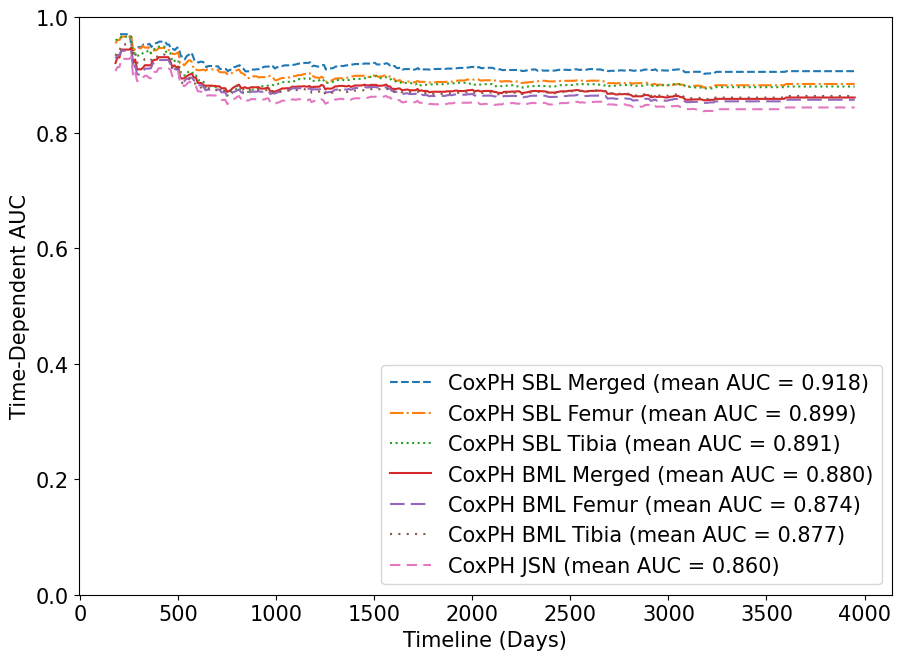

In [42]:
mean_value_1 = cindex_1[1]
ci1_lower = cindex_1[0][0]
ci1_upper = cindex_1[0][1]
plt.errorbar(x=[1], y=[mean_value_1], yerr=[[mean_value_1 - ci1_lower], [ci1_upper - mean_value_1]], fmt='o', capsize=5,label='SBL Merged')


mean_value_2 = cindex_2[1]
ci2_lower = cindex_2[0][0]
ci2_upper = cindex_2[0][1]
plt.errorbar(x=[2], y=[mean_value_2], yerr=[[mean_value_2 - ci2_lower], [ci2_upper - mean_value_2]], fmt='o', capsize=5,label='SBL Femur')


mean_value_3 = cindex_3[1]
ci3_lower = cindex_3[0][0]
ci3_upper = cindex_3[0][1]
plt.errorbar(x=[3], y=[mean_value_3], yerr=[[mean_value_3 - ci3_lower], [ci3_upper - mean_value_3]], fmt='o', capsize=5,label='SBL Tibia')

mean_value_4 = cindex_4[1]
ci4_lower = cindex_4[0][0]
ci4_upper = cindex_4[0][1]
plt.errorbar(x=[4], y=[mean_value_4], yerr=[[mean_value_4 - ci4_lower], [ci4_upper - mean_value_4]], fmt='o', capsize=5,label='BML Merged')

mean_value_5 = cindex_5[1]
ci5_lower = cindex_5[0][0]
ci5_upper = cindex_5[0][1]
plt.errorbar(x=[5], y=[mean_value_5], yerr=[[mean_value_5 - ci5_lower], [ci5_upper - mean_value_5]], fmt='o', capsize=5,label='BML Femur')

mean_value_6 = cindex_6[1]
ci6_lower = cindex_6[0][0]
ci6_upper = cindex_6[0][1]
plt.errorbar(x=[6], y=[mean_value_6], yerr=[[mean_value_6 - ci6_lower], [ci6_upper - mean_value_6]], fmt='o', capsize=5,label='BML Tibia')

mean_value_7 = cindex_7[1]
ci7_lower = cindex_7[0][0]
ci7_upper = cindex_7[0][1]
plt.errorbar(x=[7], y=[mean_value_7], yerr=[[mean_value_7 - ci7_lower], [ci7_upper - mean_value_7]], fmt='o', capsize=5,label='JSN Merged')

labels = ['SBL Merged', 'SBL Femur', 'SBL Tibia', 'BML Merged', 'BML Femur', 'BML Tibia', 'JSN Merged']
plt.xticks([])
plt.ylabel('Mean Concordance Index')
plt.title('Mean Concordance Index and 95% Confidence Interval')
plt.ylim(0,1)
# plt.legend(loc = 'lower right')
# Set x-axis ticks and labels
plt.xticks(range(1, 7 + 1), labels, rotation=45, ha='right')
plt.show()
plt.savefig('/home/tsurendr/Error_bar_Plots/Multivariate/all_knees_RAW_Cindex.pdf', format='pdf', bbox_inches = 'tight')

In [ ]:
mean_value_1 = brier_1[1]
ci1_lower = brier_1[0][0]
ci1_upper = brier_1[0][1]
print(ci1_lower, ci1_upper, mean_value_1)
plt.errorbar(x=[1], y=[mean_value_1], yerr=[[mean_value_1 - ci1_lower], [ci1_upper - mean_value_1]], fmt='o', capsize=5,label='SBL Merged')


mean_value_2 = brier_2[1]
ci2_lower = brier_2[0][0]
ci2_upper = brier_2[0][1]
plt.errorbar(x=[2], y=[mean_value_2], yerr=[[mean_value_2 - ci2_lower], [ci2_upper - mean_value_2]], fmt='o', capsize=5,label='SBL Femur')


mean_value_3 = brier_3[1]
ci3_lower = brier_3[0][0]
ci3_upper = brier_3[0][1]
plt.errorbar(x=[3], y=[mean_value_3], yerr=[[mean_value_3 - ci3_lower], [ci3_upper - mean_value_3]], fmt='o', capsize=5,label='SBL Tibia')

mean_value_4 = brier_4[1]
ci4_lower = brier_4[0][0]
ci4_upper = brier_4[0][1]
plt.errorbar(x=[4], y=[mean_value_4], yerr=[[mean_value_4 - ci4_lower], [ci4_upper - mean_value_4]], fmt='o', capsize=5,label='BML Merged')

mean_value_5 = brier_5[1]
ci5_lower = brier_5[0][0]
ci5_upper = brier_5[0][1]
plt.errorbar(x=[5], y=[mean_value_5], yerr=[[mean_value_5 - ci5_lower], [ci5_upper - mean_value_5]], fmt='o', capsize=5,label='BML Femur')

mean_value_6 = brier_6[1]
ci6_lower = brier_6[0][0]
ci6_upper = brier_6[0][1]
plt.errorbar(x=[6], y=[mean_value_6], yerr=[[mean_value_6 - ci6_lower], [ci6_upper - mean_value_6]], fmt='o', capsize=5,label='BML Tibia')

mean_value_7 = brier_7[1]
ci7_lower = brier_7[0][0]
ci7_upper = brier_7[0][1]
plt.errorbar(x=[7], y=[mean_value_7], yerr=[[mean_value_7 - ci7_lower], [ci7_upper - mean_value_7]], fmt='o', capsize=5,label='JSN Merged')

labels = ['SBL Merged', 'SBL Femur', 'SBL Tibia', 'BML Merged', 'BML Femur', 'BML Tibia', 'JSN Merged']
plt.xticks([])
plt.ylabel('Mean Brier Score')
plt.title('Mean Brier Score and 95% Confidence Interval')
# plt.ylim(0,1)
# plt.legend(loc = 'lower right')
# Set x-axis ticks and labels
plt.xticks(range(1, 7 + 1), labels, rotation=45, ha='right')
plt.show()
plt.savefig('/home/tsurendr/Error_bar_Plots/Multivariate/all_knees_RAW_brier.pdf', format='pdf', bbox_inches = 'tight')

In [ ]:
mean_value_1 = auc_1[1]
ci1_lower = auc_1[0][0]
ci1_upper = auc_1[0][1]
print(ci1_lower, ci1_upper, mean_value_1)
plt.errorbar(x=[1], y=[mean_value_1], yerr=[[mean_value_1 - ci1_lower], [ci1_upper - mean_value_1]], fmt='o', capsize=5,label='SBL Merged')


mean_value_2 = auc_2[1]
ci2_lower = auc_2[0][0]
ci2_upper = auc_2[0][1]
plt.errorbar(x=[2], y=[mean_value_2], yerr=[[mean_value_2 - ci2_lower], [ci2_upper - mean_value_2]], fmt='o', capsize=5,label='SBL Femur')


mean_value_3 = auc_3[1]
ci3_lower = auc_3[0][0]
ci3_upper = auc_3[0][1]
plt.errorbar(x=[3], y=[mean_value_3], yerr=[[mean_value_3 - ci3_lower], [ci3_upper - mean_value_3]], fmt='o', capsize=5,label='SBL Tibia')

mean_value_4 = auc_4[1]
ci4_lower = auc_4[0][0]
ci4_upper = auc_4[0][1]
plt.errorbar(x=[4], y=[mean_value_4], yerr=[[mean_value_4 - ci4_lower], [ci4_upper - mean_value_4]], fmt='o', capsize=5,label='BML Merged')

mean_value_5 = auc_5[1]
ci5_lower = auc_5[0][0]
ci5_upper = auc_5[0][1]
plt.errorbar(x=[5], y=[mean_value_5], yerr=[[mean_value_5 - ci5_lower], [ci5_upper - mean_value_5]], fmt='o', capsize=5,label='BML Femur')

mean_value_6 = auc_6[1]
ci6_lower = auc_6[0][0]
ci6_upper = auc_6[0][1]
plt.errorbar(x=[6], y=[mean_value_6], yerr=[[mean_value_6 - ci6_lower], [ci6_upper - mean_value_6]], fmt='o', capsize=5,label='BML Tibia')

mean_value_7 = auc_7[1]
ci7_lower = auc_7[0][0]
ci7_upper = auc_7[0][1]
plt.errorbar(x=[7], y=[mean_value_7], yerr=[[mean_value_7 - ci7_lower], [ci7_upper - mean_value_7]], fmt='o', capsize=5,label='JSN Merged')

labels = ['SBL Merged', 'SBL Femur', 'SBL Tibia', 'BML Merged', 'BML Femur', 'BML Tibia', 'JSN Merged']
plt.xticks([])
plt.ylabel('Average Mean Time-Dependent AUC')
plt.title('Average Mean Time-Dependent AUC and 95% Confidence Interval')
plt.ylim(0,1)
# plt.legend(loc = 'lower right')
# Set x-axis ticks and labels
plt.xticks(range(1, 7 + 1), labels, rotation=45, ha='right')
plt.show()
plt.savefig('/home/tsurendr/Error_bar_Plots/Multivariate/all_knees_RAW_AUC.pdf', format='pdf', bbox_inches = 'tight')

In [ ]:

# Column names
columns = ['Cindex', 'Brier', 'AUC']

# Create an empty DataFrame
table_df = pd.DataFrame(columns=columns)


row_1 = {'Cindex': cindex_1, 'Brier': brier_1, 'AUC': auc_1}
row_2 = {'Cindex': cindex_2, 'Brier': brier_2, 'AUC': auc_2}
row_3 = {'Cindex': cindex_3, 'Brier': brier_3, 'AUC': auc_3}
row_4 = {'Cindex': cindex_4, 'Brier': brier_4, 'AUC': auc_4}
row_5 = {'Cindex': cindex_5, 'Brier': brier_5, 'AUC': auc_5}
row_6 = {'Cindex': cindex_6, 'Brier': brier_6, 'AUC': auc_6}
row_7 = {'Cindex': cindex_7, 'Brier': brier_7, 'AUC': auc_7}
table_df = table_df.append(row_1, ignore_index=True)
table_df = table_df.append(row_2, ignore_index=True)
table_df = table_df.append(row_3, ignore_index=True)
table_df = table_df.append(row_4, ignore_index=True)
table_df = table_df.append(row_5, ignore_index=True)
table_df = table_df.append(row_6, ignore_index=True)
table_df = table_df.append(row_7, ignore_index=True)
table_df.to_csv('/home/tsurendr/TABLES/all_knees_Multivariate_RAW.csv', index=False)